In [9]:
pip install torch numpy torchvision matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd


cudnn.benchmark = True
plt.ion()

In [11]:
# class CustomImageDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file)
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [12]:
# def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#     self.img_labels = pd.read_csv(annotations_file)
#     self.img_dir = img_dir
#     self.transform = transform
#     self.target_transform = target_transform

In [13]:
# def __len__(self):
#     return len(self.img_labels)

In [14]:
# def __getitem__(self, idx):
#     img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#     image = read_image(img_path)
#     label = self.img_labels.iloc[idx, 1]
#     if self.transform:
#         image = self.transform(image)
#     if self.target_transform:
#         label = self.target_transform(label)
#     return image, label

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]),
}

training_data = {x: datasets.FashionMNIST(root=".", download=True, transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(training_data[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(training_data[x]) for x in ['train', 'val']}

class_names = training_data['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


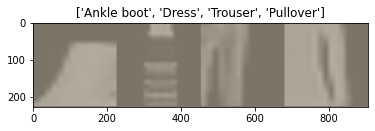

In [16]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.4166 Acc: 0.5254
val Loss: 0.6995 Acc: 0.7646

Epoch 1/4
----------
train Loss: 1.3477 Acc: 0.5561
val Loss: 0.6048 Acc: 0.7909

Epoch 2/4
----------
train Loss: 1.3491 Acc: 0.5590
val Loss: 0.8347 Acc: 0.7397

Epoch 3/4
----------
train Loss: 1.3298 Acc: 0.5623
val Loss: 0.8044 Acc: 0.7495

Epoch 4/4
----------
train Loss: 1.3296 Acc: 0.5655
val Loss: 0.6687 Acc: 0.7802

Training complete in 213m 12s
Best val Acc: 0.790867


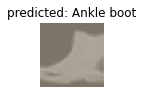

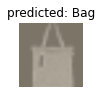

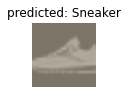

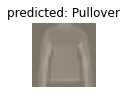

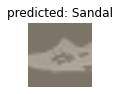

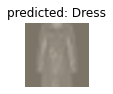

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()